# Sample Lya posterior as a function of nuisance parameters

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
import corner
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler

### Setup Lya likelihood function

In [3]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z

In [4]:
basedir=None
p1d_label=None
skewers_label=None
undersample_z=3
emu_type='polyGP'
if emu_type=='polyGP':
    emu=gp_emulator.PolyfitGPEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,
                               verbose=True,paramList=None,kmax_Mpc=5,train=True)
elif emu_type=='kGP':
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,
                               verbose=True,paramList=None,kmax_Mpc=5,train=True)
elif emu_type=='linear':
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,
                                       verbose=False)
else:
    raise ValueError('wrong emulator type '+emu_type)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.972, 0.42000000000000004, -2.315, -0.19, 0.7250000000000001, 1.3250000000000002], '1': [0.96, 0.28, -2.295, -0.2, 1.3250000000000002, 1.475], '2': [0.966, 0.3, -2.305, -0.26, 1.025, 0.875], '3': [0.956, 0.4, -2.275, -0.25, 0.575, 1.175], '4': [0.968, 0.44, -2.325, -0.22, 1.475, 0.7250000000000001], '5': [

In [5]:
# specify free parameters in likelihood
#free_parameters=['ln_kF_0']
#free_parameters=['ln_tau_0','ln_tau_1']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_gamma_0']
free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_gamma_0','ln_kF_0']

In [6]:
sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,verbose=True)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
setup with 50 walkers
set 50 walkers with 5 dimensions
done setting up sampler


In [7]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

ln_tau_0 -0.794580172414 -1.5 -0.4
ln_tau_1 3.18 3.0 5.0
ln_T0_0 9.21034037198 8.51719319142 10.8197782844
ln_gamma_0 0.336472236621 0.0953101798043 0.69314718056
ln_kF_0 -1.70374859191 -2.99573227355 -0.69314718056


### Run burn-in chains

In [8]:
sampler.like.go_silent()

In [9]:
sampler.run_burn_in(nsteps=50)

start burn-in, will do 50 steps
0 [ 0.52035743  0.3674797   0.45706962  0.52988303  0.4072723 ]
20 [ 0.53827294  0.34469019  0.47070246  0.54735432  0.43145776]
40 [ 0.53826449  0.34439585  0.51238415  0.61065332  0.42785864]
finished burn-in


### Run main chains

In [12]:
sampler.run_chains(nsteps=200)

0 [ 0.4883968   0.46695524  0.45034931  0.47859686  0.46931531]
20 [ 0.52905358  0.49733762  0.45837184  0.55946332  0.50519042]
40 [ 0.50121587  0.49961516  0.51760309  0.57287123  0.50576295]
60 [ 0.47659176  0.53300206  0.55154776  0.57219724  0.50453253]
80 [ 0.43675481  0.58107852  0.58613173  0.56540403  0.49804642]
100 [ 0.41763322  0.60978309  0.60599738  0.55549629  0.4947731 ]
120 [ 0.39622841  0.63586916  0.61119369  0.55664819  0.49439909]
140 [ 0.39228133  0.64206853  0.61677581  0.5554178   0.49249934]
160 [ 0.38228757  0.66545809  0.63343074  0.55182364  0.48592474]
180 [ 0.38065363  0.6694732   0.64560599  0.55107657  0.48061761]


In [13]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.sampler.acceptance_fraction)))

Mean acceptance fraction: 0.125


### Plot results in cube units (0 < x < 1)

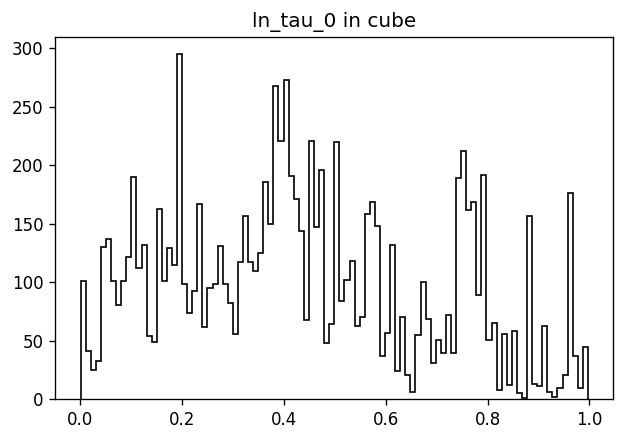

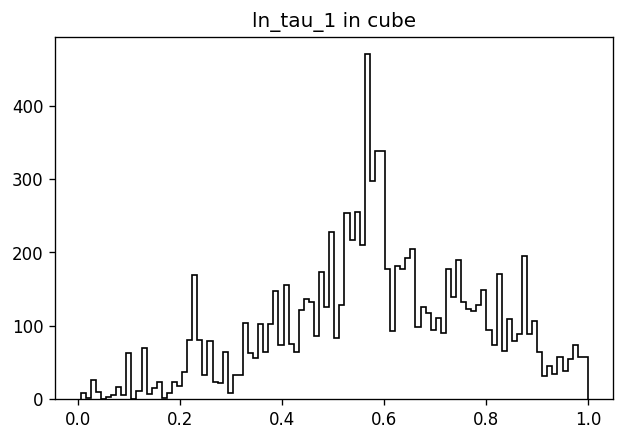

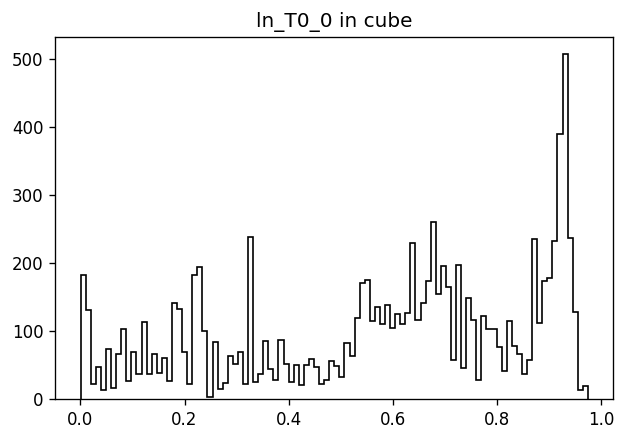

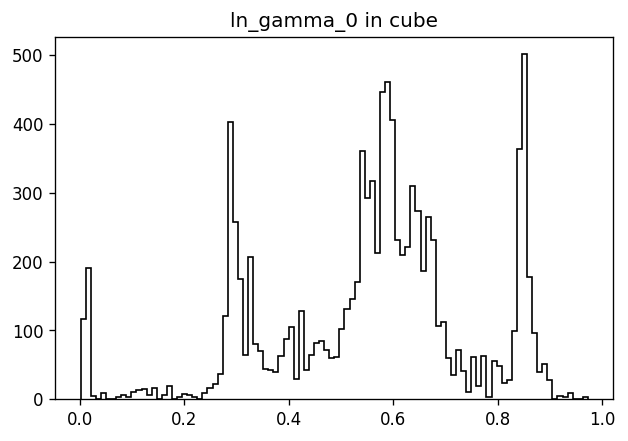

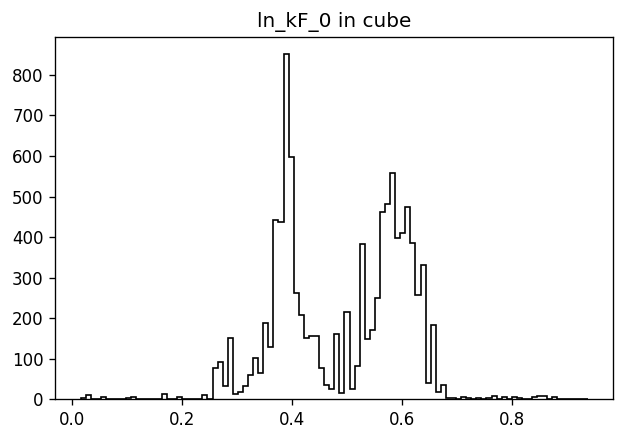

In [14]:
sampler.plot_histograms(cube=True)

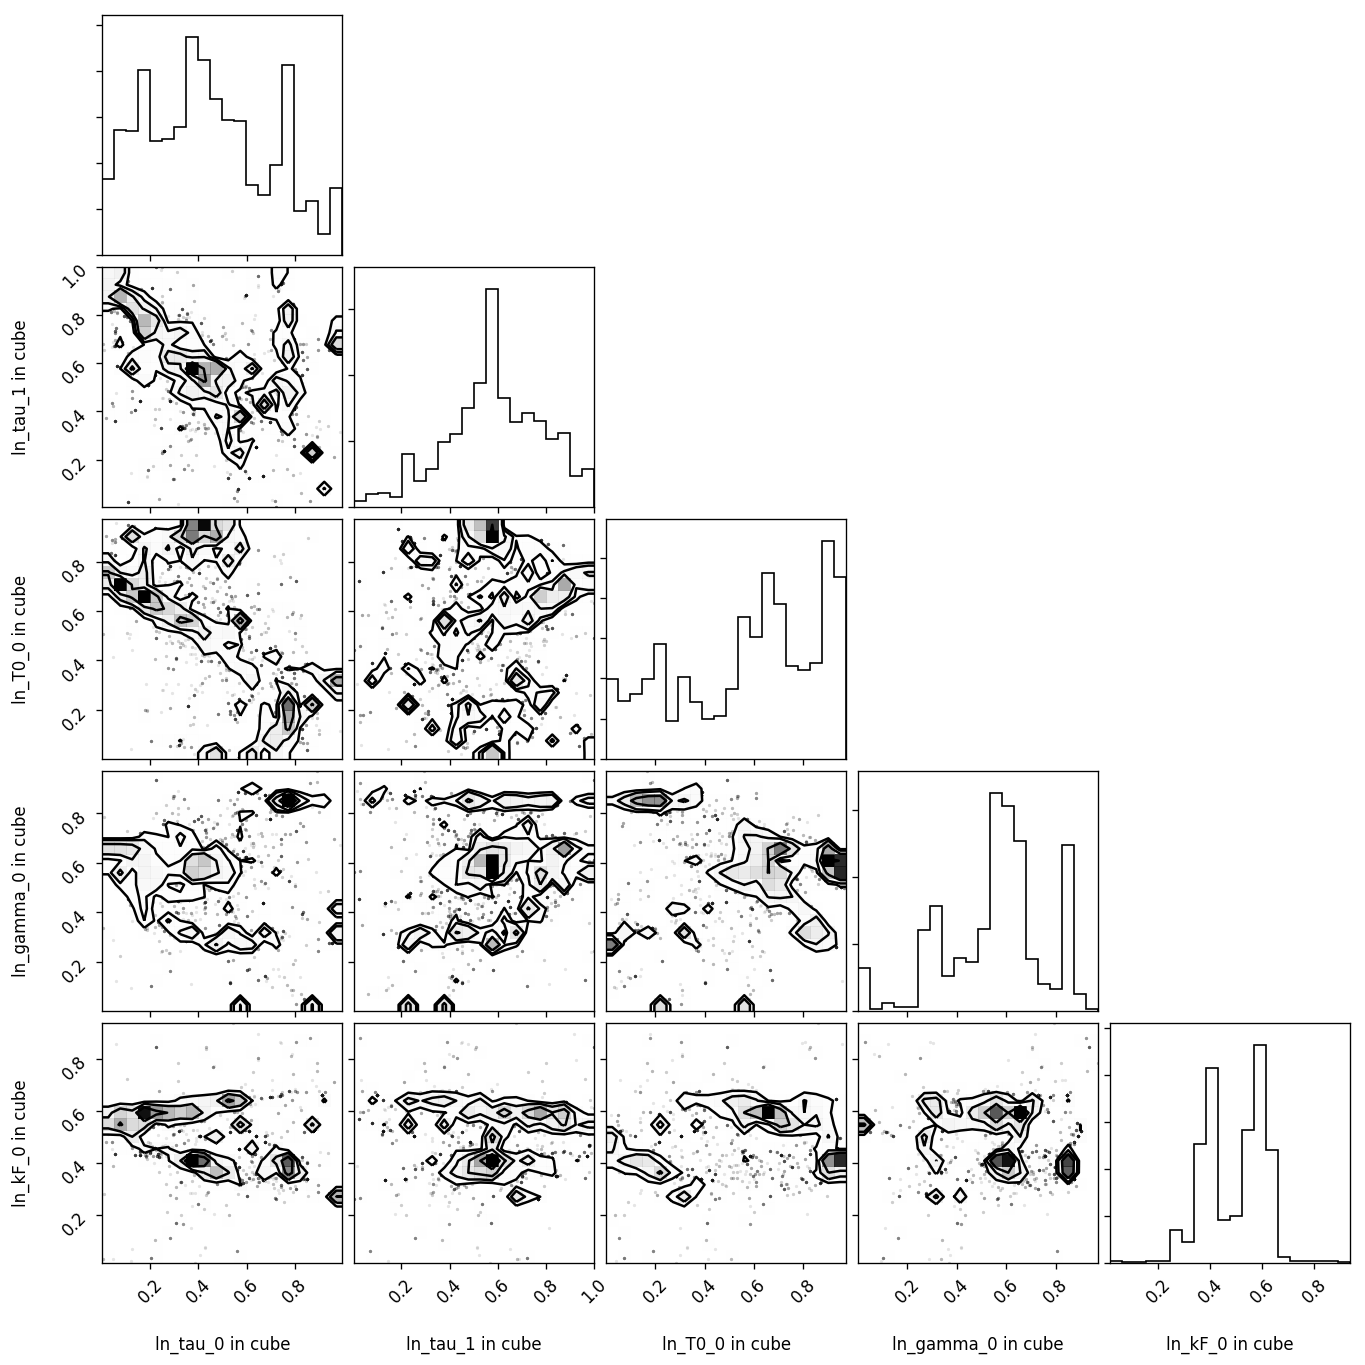

In [15]:
sampler.plot_corner(cube=True)

### Plot results for dimensional parameters

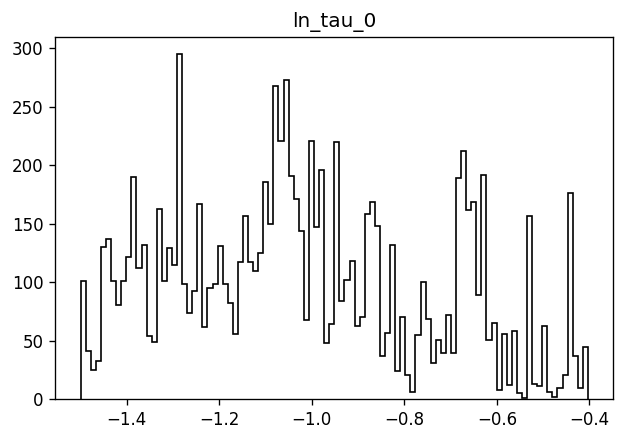

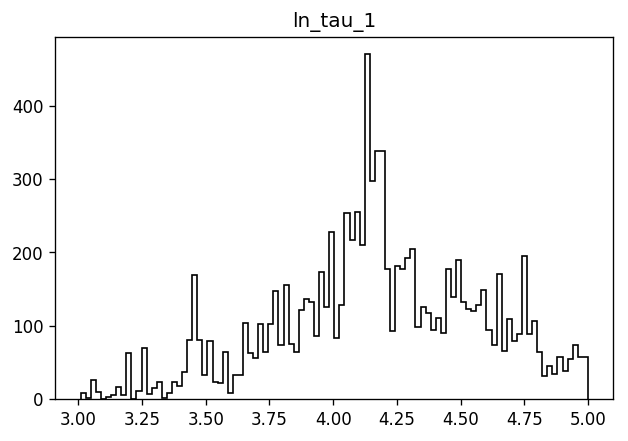

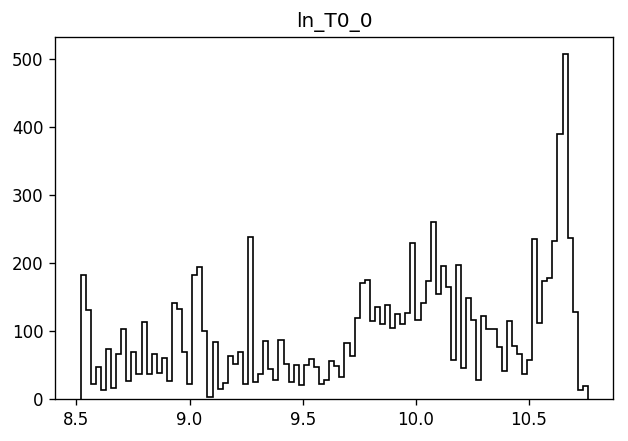

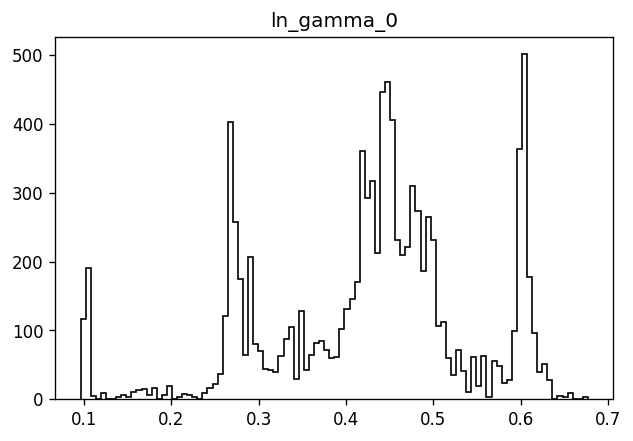

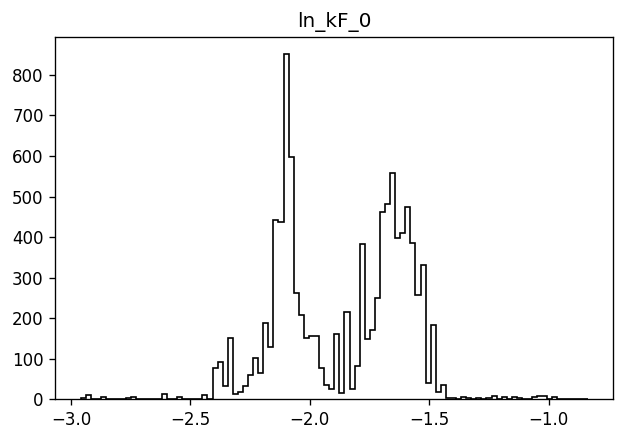

In [16]:
sampler.plot_histograms(cube=False)

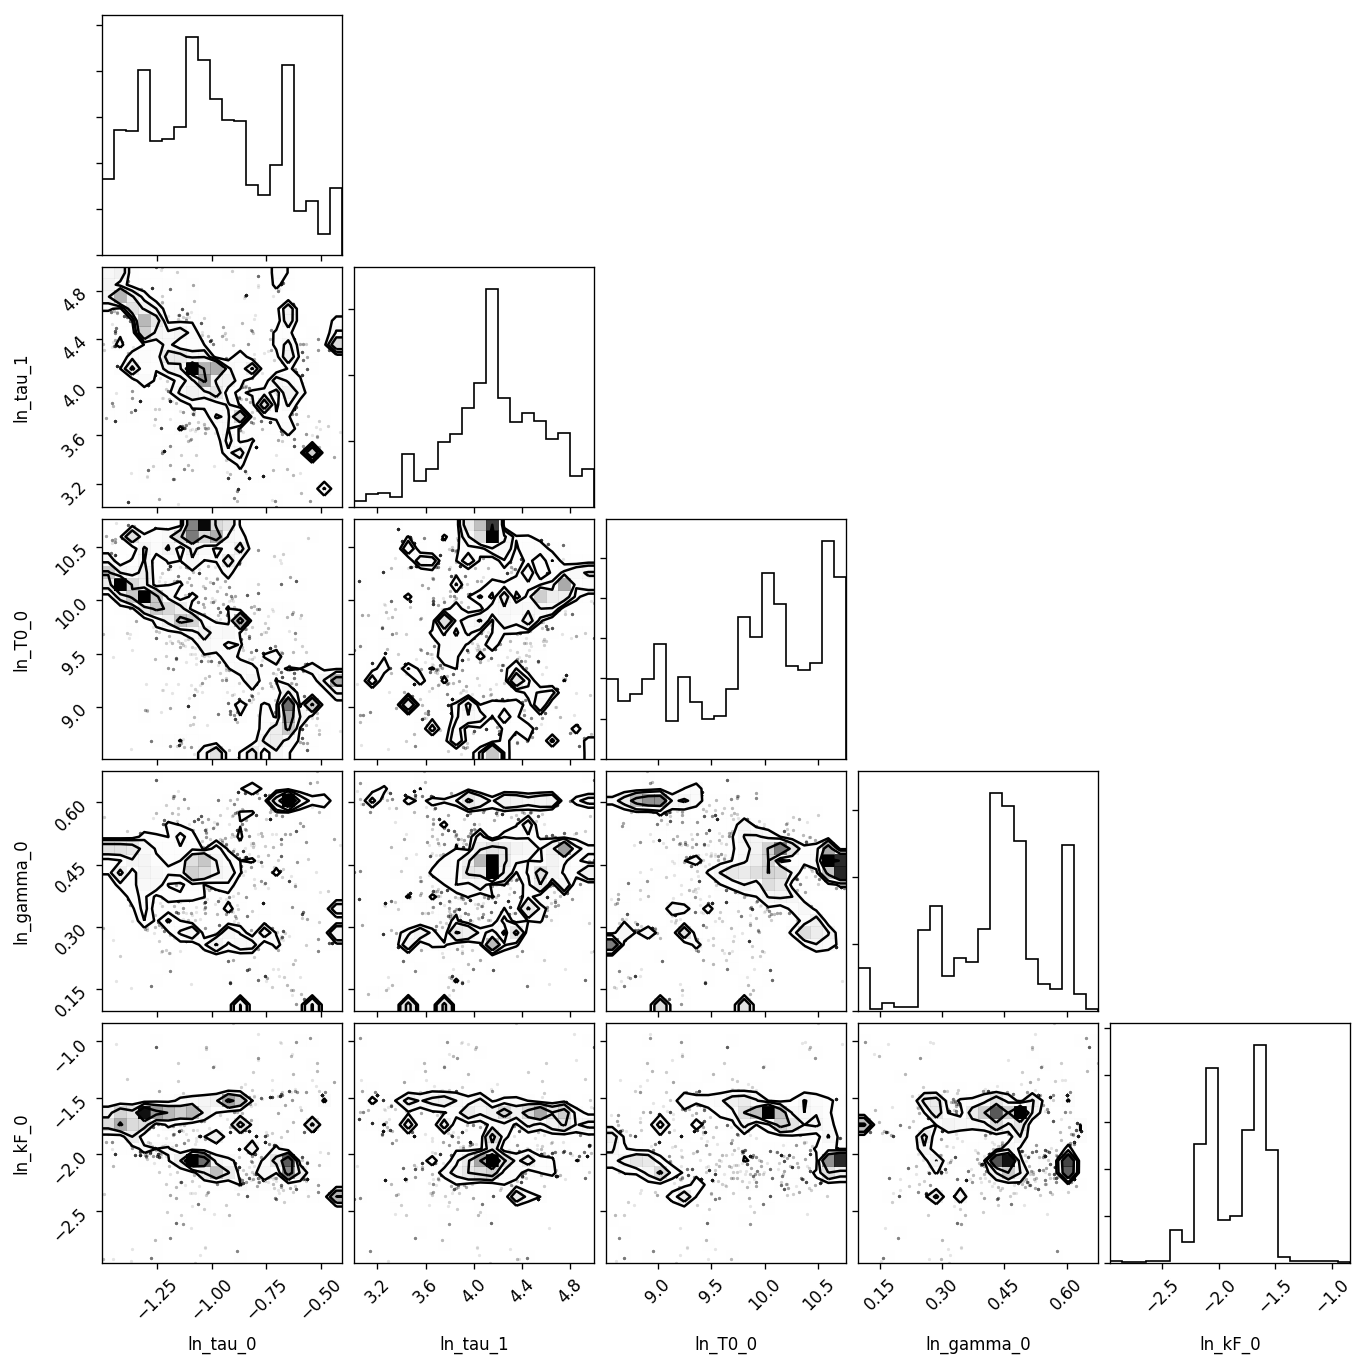

In [17]:
sampler.plot_corner(cube=False)

### Use likelihood object to make other useful plots

In [18]:
# get mean of chain
mcmc_mean=np.mean(sampler.sampler.flatchain,axis=0)
print('mean point',mcmc_mean)

mean point [ 0.43663975  0.58893708  0.57760179  0.55655237  0.49339326]


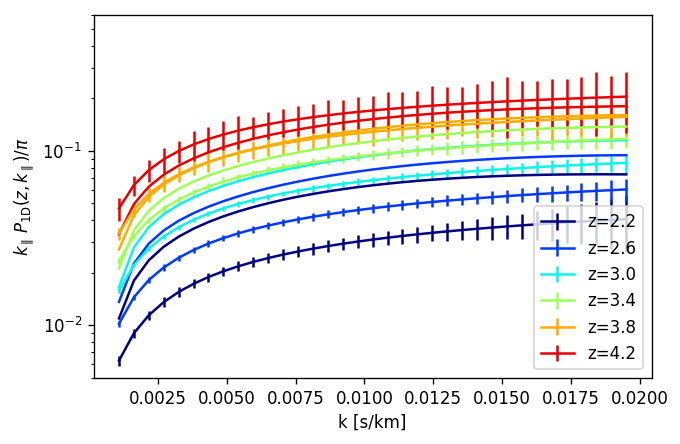

In [19]:
sampler.like.plot_p1d(values=mcmc_mean,plot_every_iz=2)

In [20]:
# get best fit model
ind = np.unravel_index(np.argmax(sampler.sampler.lnprobability, axis=None), sampler.sampler.lnprobability.shape)
best_fit=sampler.sampler.chain[ind]

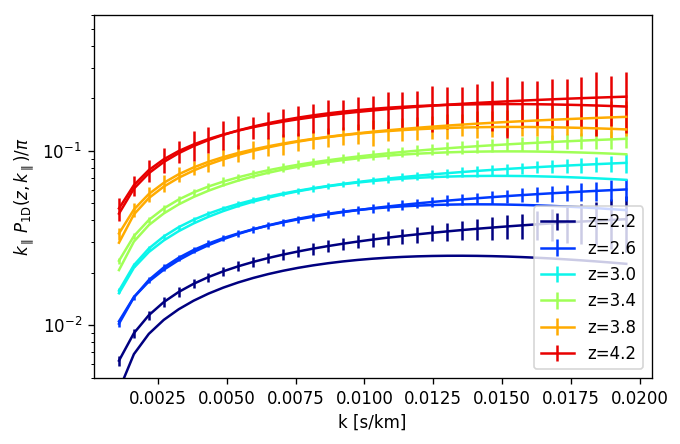

In [21]:
sampler.like.plot_p1d(values=best_fit,plot_every_iz=2)

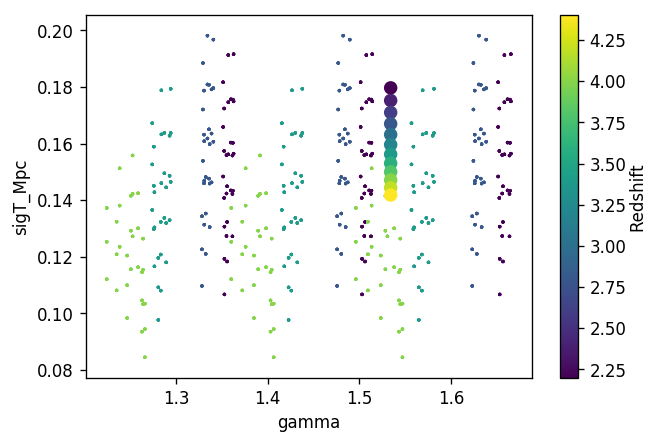

In [22]:
sampler.like.overplot_emulator_calls('gamma','sigT_Mpc',values=mcmc_mean)

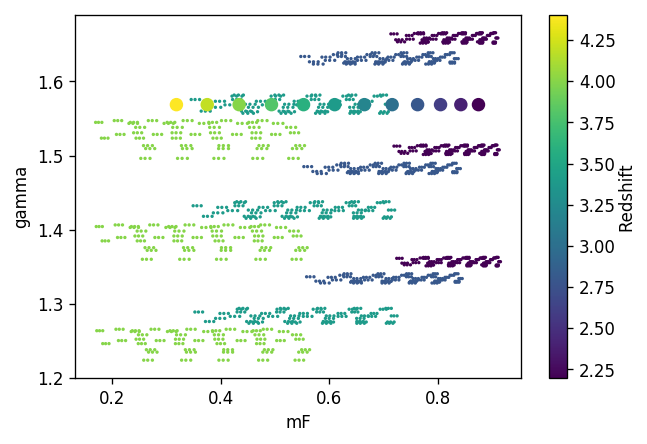

In [23]:
sampler.like.overplot_emulator_calls('mF','gamma',values=best_fit)

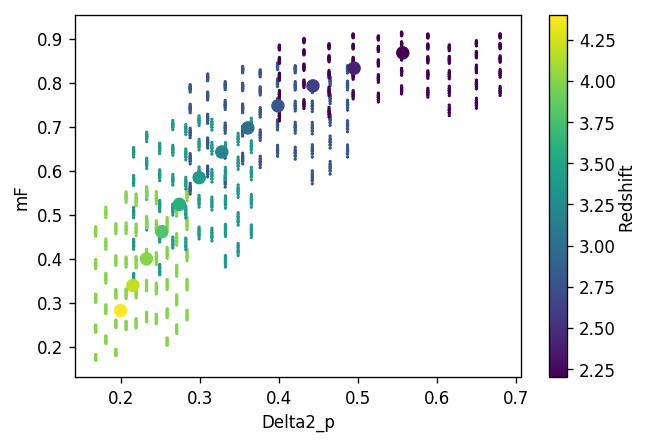

In [24]:
sampler.like.overplot_emulator_calls('Delta2_p','mF',values=mcmc_mean)

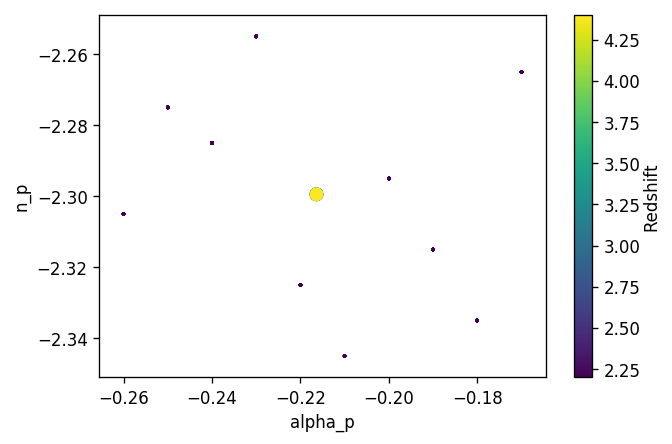

In [25]:
sampler.like.overplot_emulator_calls('alpha_p','n_p',values=mcmc_mean)

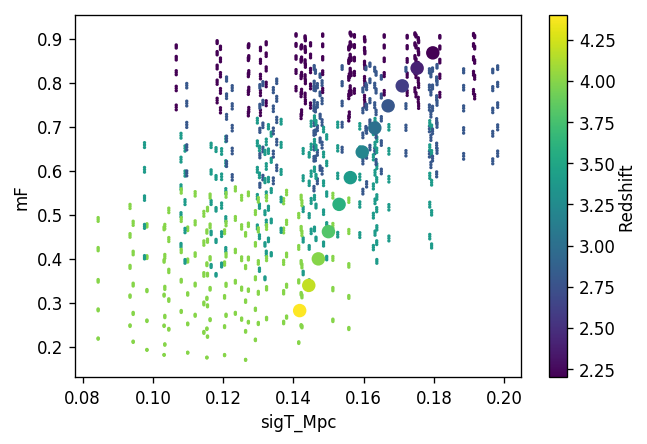

In [26]:
sampler.like.overplot_emulator_calls('sigT_Mpc','mF',values=mcmc_mean)

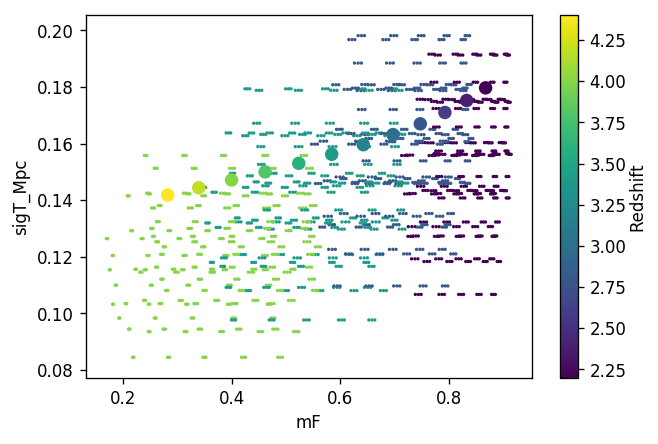

In [27]:
sampler.like.overplot_emulator_calls('mF','sigT_Mpc',values=mcmc_mean)

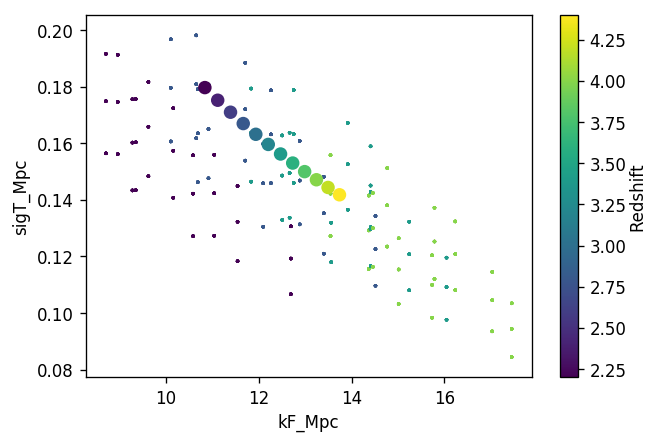

In [28]:
sampler.like.overplot_emulator_calls('kF_Mpc','sigT_Mpc',values=mcmc_mean)

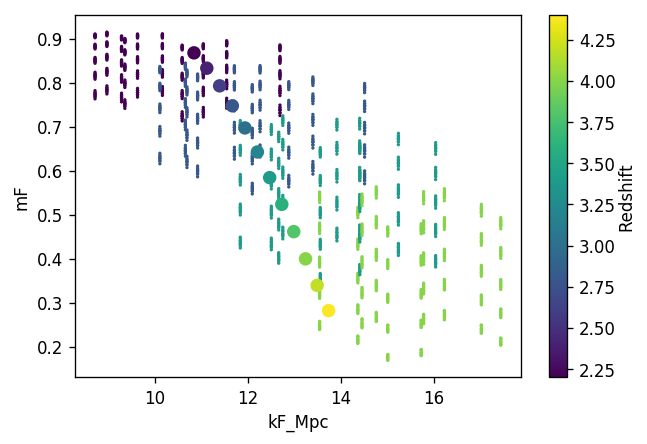

In [29]:
sampler.like.overplot_emulator_calls('kF_Mpc','mF',values=mcmc_mean)

### Write chain to file for later use

In [30]:
chain_filename='test'
sampler.write_chain_to_file(chain_filename)

### Read pre-computed chain

In [31]:
new_sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,
                                         read_chain_file=chain_filename,verbose=True)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
will read chain from file test
done setting up sampler


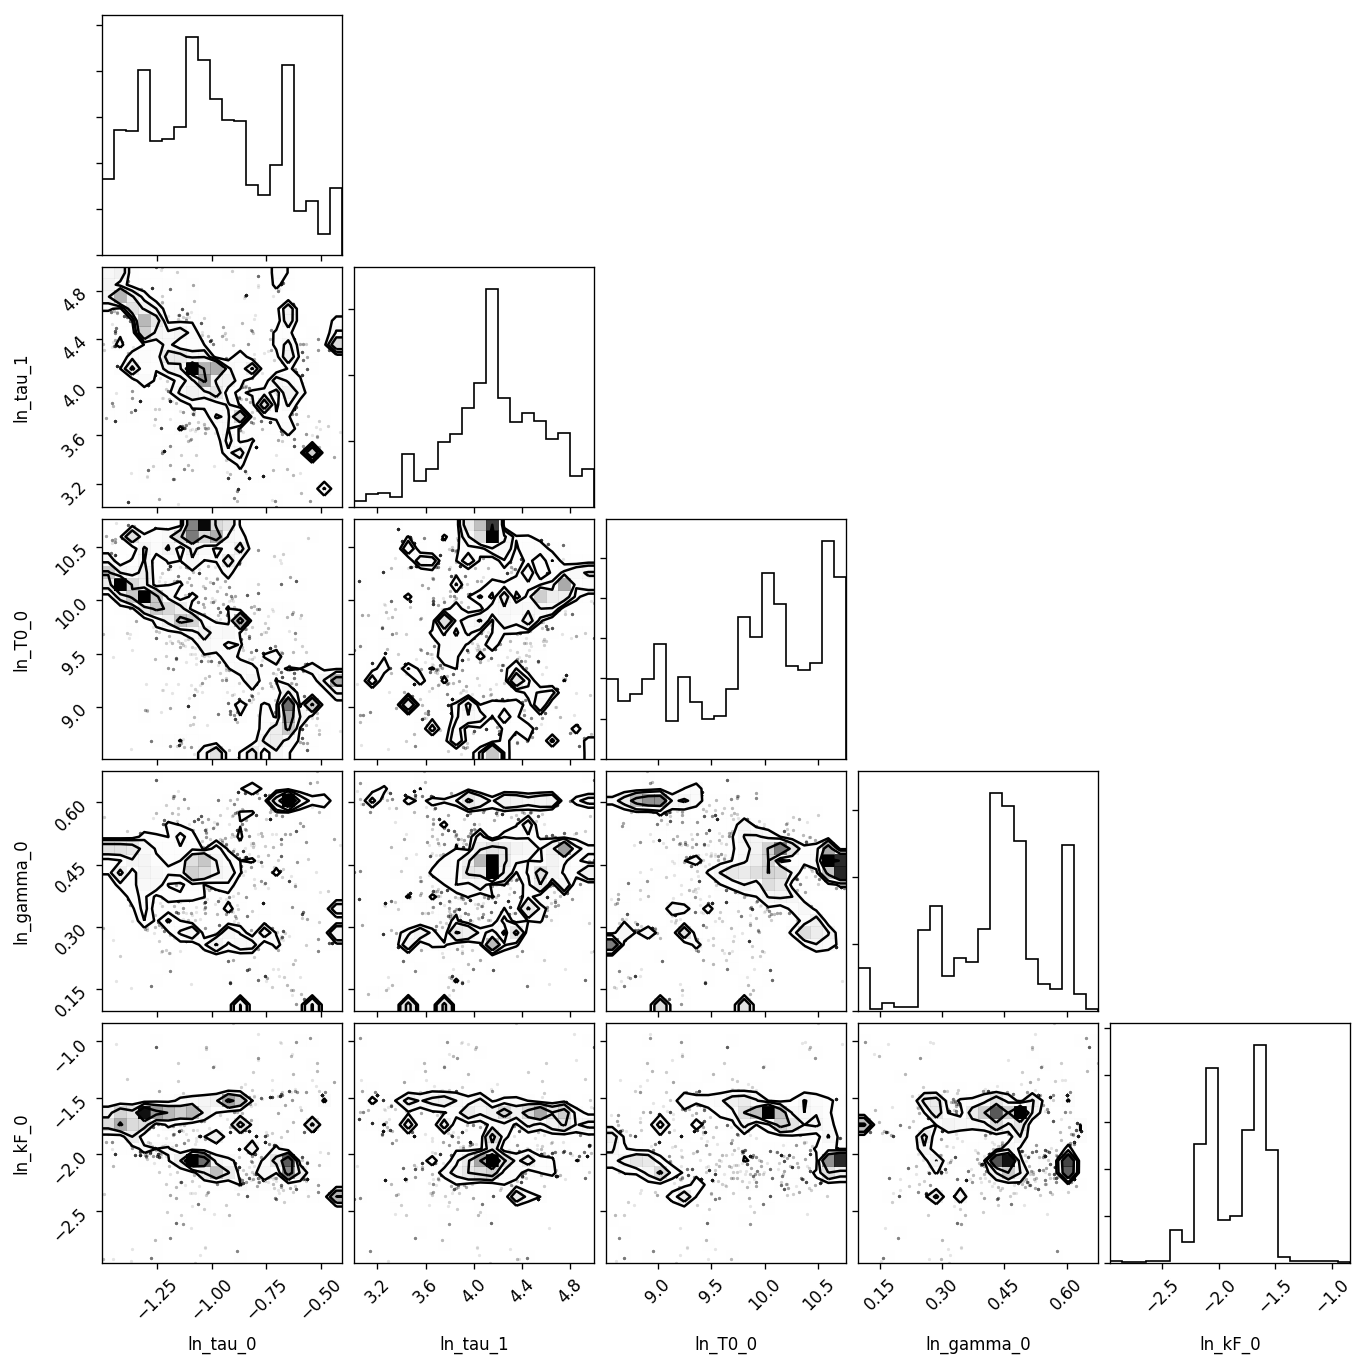

In [32]:
new_sampler.plot_corner(cube=False)

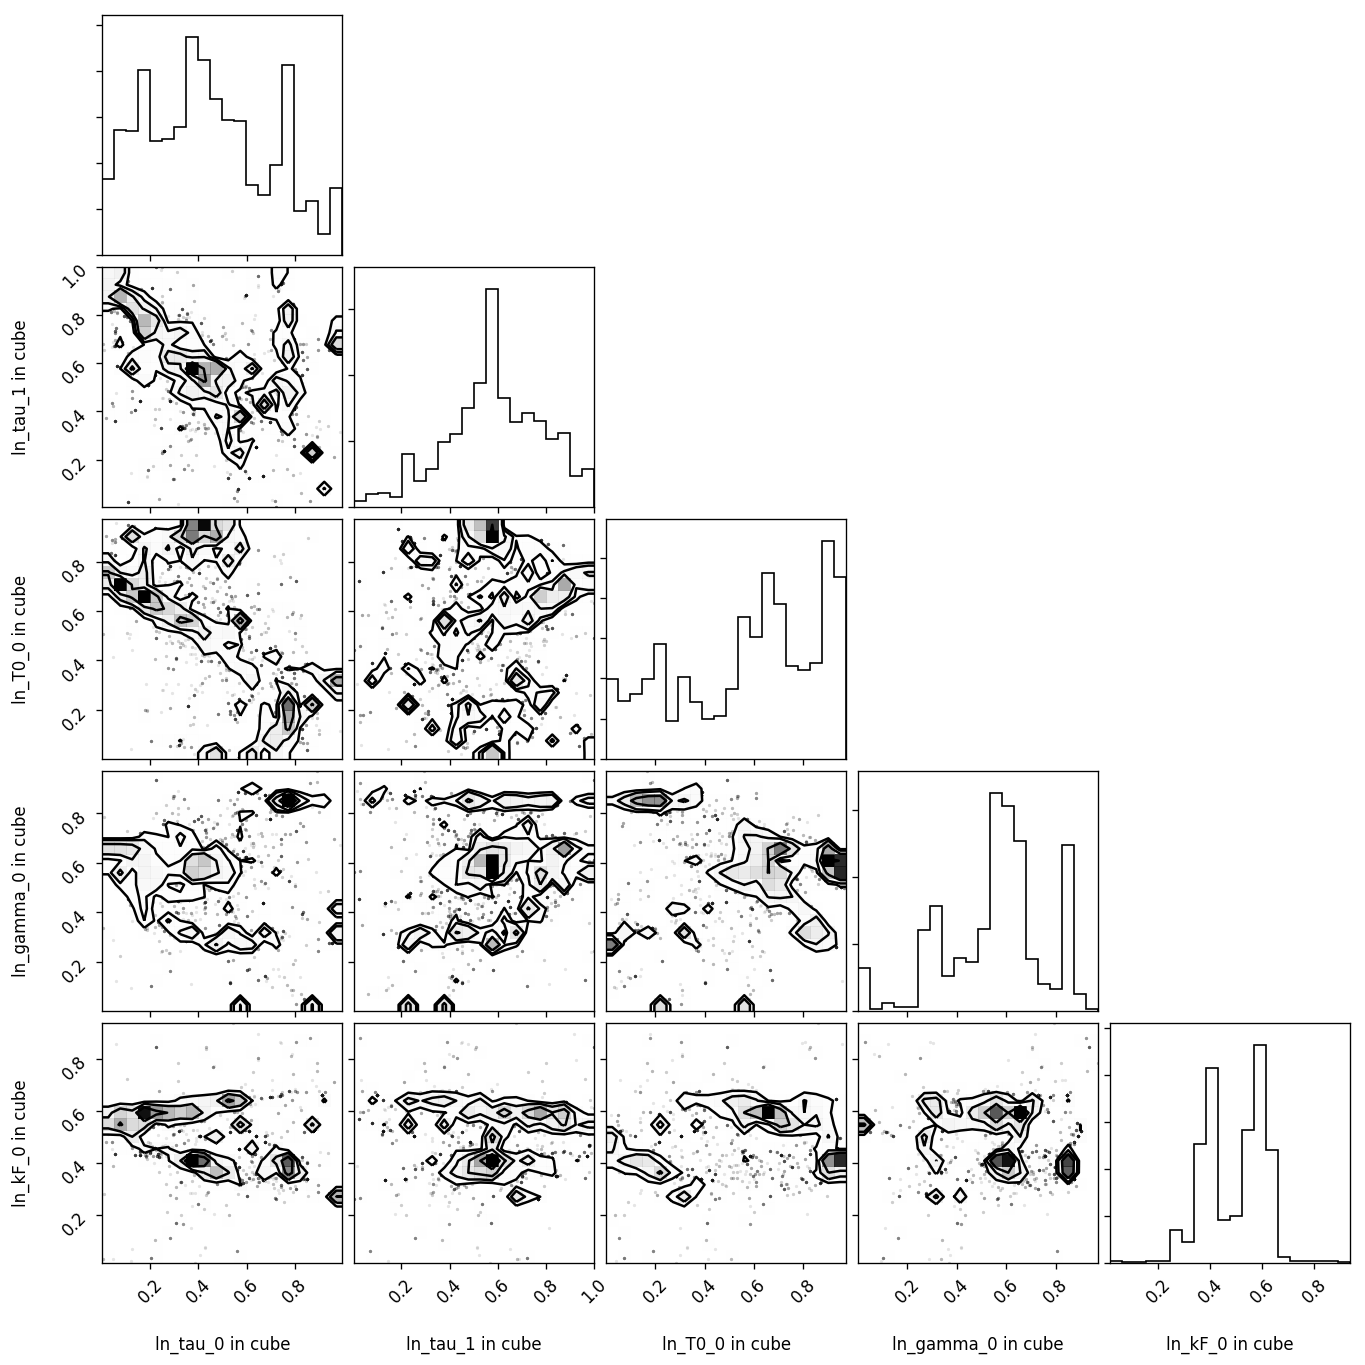

In [33]:
new_sampler.plot_corner(cube=True)

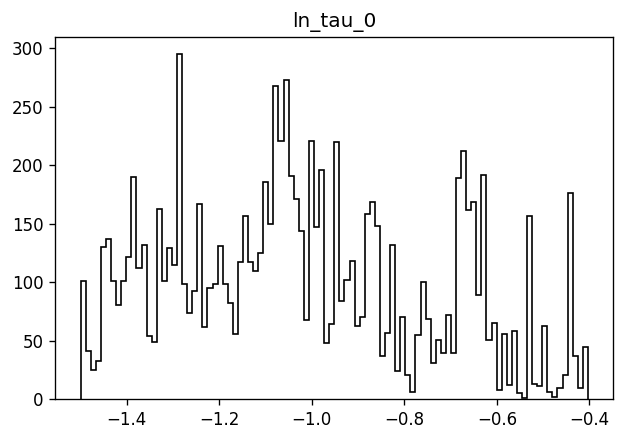

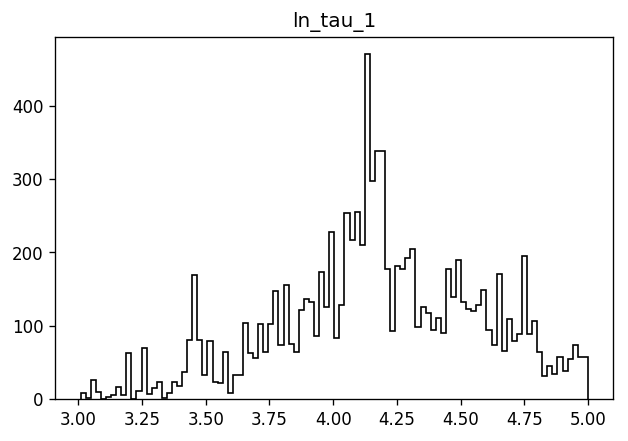

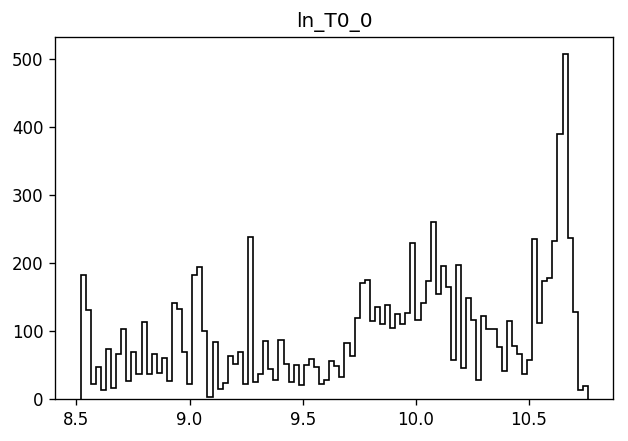

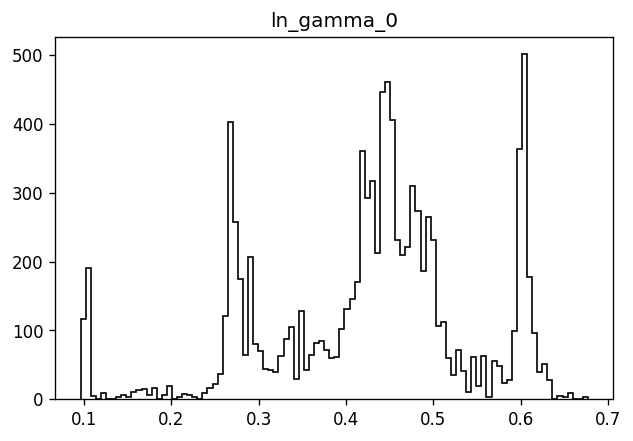

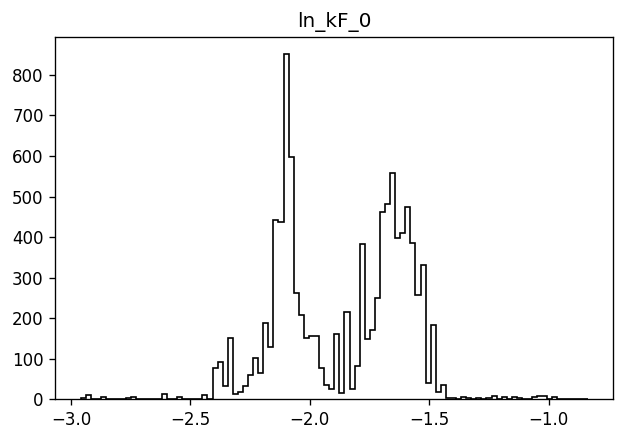

In [34]:
new_sampler.plot_histograms(cube=False)